## 과제 2: 영화 평점과 흥행 수익 간의 상관관계 분석
사용자 평점, 비평가 평점, 박스오피스 수익 간의 관계를 분석하고, 평점이 높지만 흥행하지 못한 영화와 평점은 낮지만 흥행한 영화들의 특성을 비교 분석하세요.

분석 대상 영화 수: 85


,movie_id,title,original_title,original_language,release_date,runtime,budget,revenue,vote_average,vote_count,popularity,genres,production_companies,production_countries,release_year,release_month,roi
1,1255,괴물,괴물,ko,2006-07-27,119,11000000,88489643,6.980,2931,4.4383,"['공포', '드라마', 'SF']","['Chungeorahm Film', 'Showbox']",['KR'],2006,7,7.044513
2,1963,활,활,ko,2005-05-12,88,950000,2032404,6.921,208,1.2098,['드라마'],"['Kim Ki Duk Film', 'Happinet Pictures', 'Cine...","['JP', 'KR']",2005,5,1.139373
3,2015,밀양,밀양,ko,2007-05-23,142,2900000,11581469,7.193,215,1.6151,['드라마'],"['Cinema Service', 'Pinehouse Film', 'CJ Enter...",['KR'],2007,5,2.993610


Pearson(vote_average, log(1+revenue)) = 0.359
Spearman(vote_average, revenue)      = 0.393


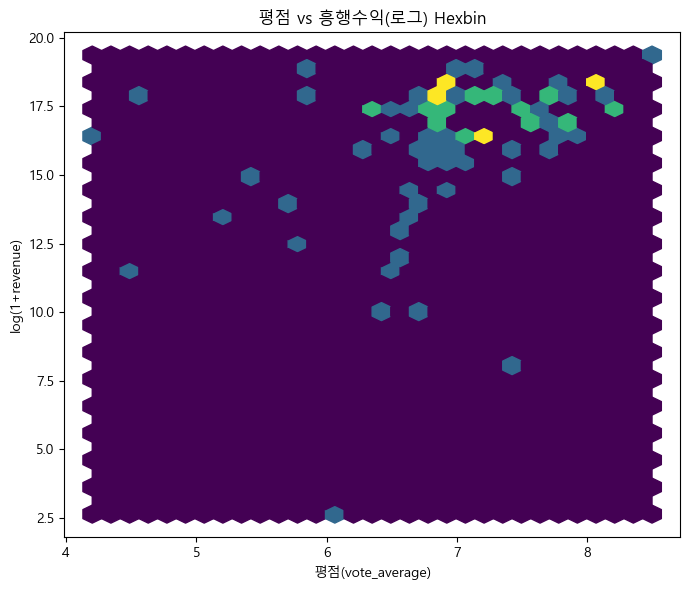

C:\Users\amy\AppData\Local\Temp\ipykernel_26076\2360190050.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("vote_decile").agg(mean_log_revenue=("log_revenue","mean"),


,mean_log_revenue,n
vote_decile,,
1,15.188456,9
2,13.592404,8
3,14.320490,9
4,16.851023,8
5,16.775670,9
6,17.197816,8
7,17.325432,8
8,15.876642,9
9,17.062545,8


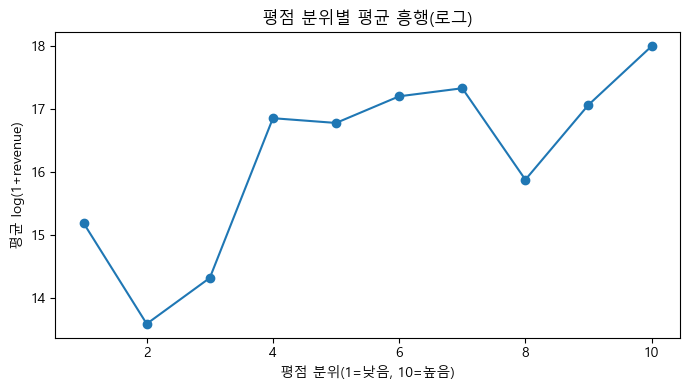

고평점·저흥행  N: 0
저평점·고흥행  N: 2


,HighRating_LowRevenue,LowRating_HighRevenue
N,0.0,2.000000e+00
median_budget,NaN,3.700000e+07
median_revenue,NaN,9.799726e+07
median_roi,NaN,1.612692e+00
median_runtime,NaN,8.900000e+01
median_vote_count,NaN,7.140000e+02
top_release_month,NaN,1.000000e+00


,고평점·저흥행%,저평점·고흥행%
release_month,,
1,0.0,50.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,50.0
9,0.0,0.0


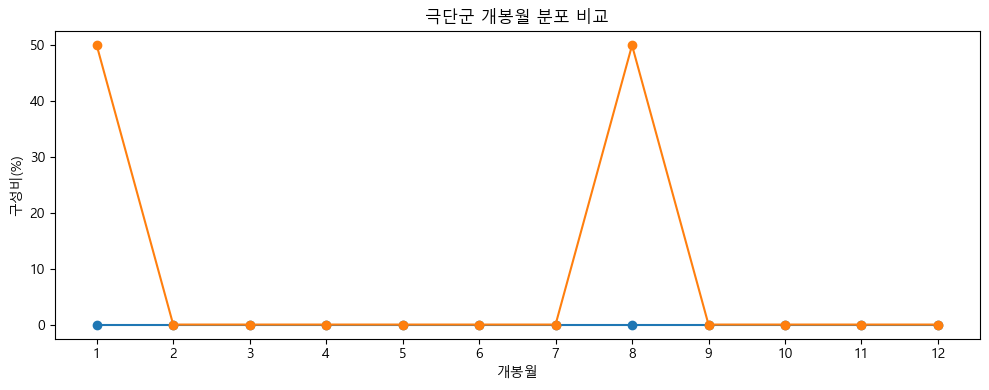

,고평점·저흥행,저평점·고흥행
genres,,
드라마,0,1
모험,0,1
코미디,0,1
액션,0,1
SF,0,1
스릴러,0,1
공포,0,1
애니메이션,0,1
판타지,0,1


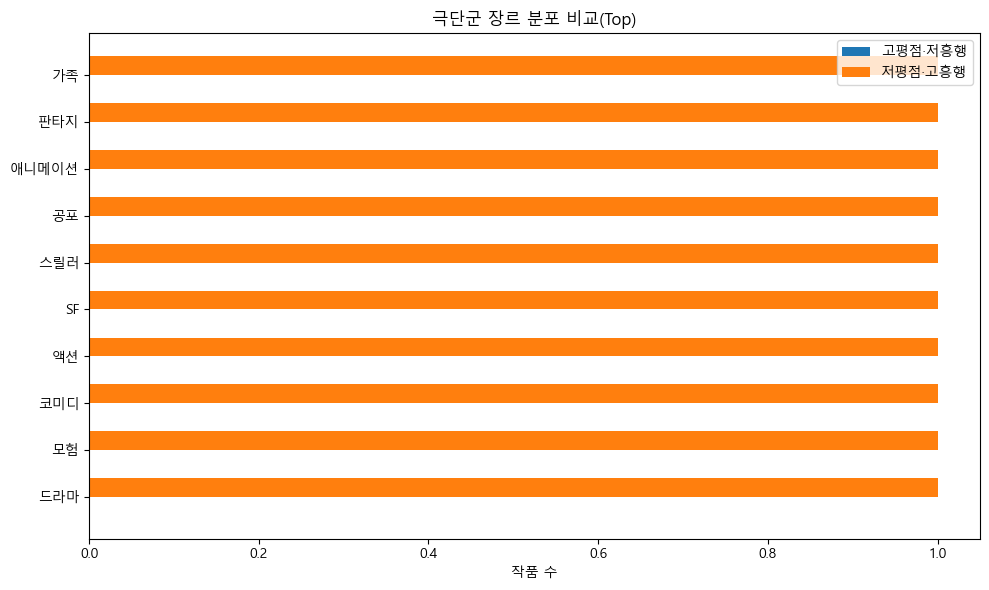

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

PATH_CLEAN = "./data_processed/tmdb_kr_theatrical_clean.csv"
PATH_EXP   = "./data_processed/tmdb_kr_theatrical_clean_exploded.csv"  # 장르 비교용(옵션)

df = pd.read_csv(PATH_CLEAN)

# 숫자형 캐스팅 & 기간 필터(안전)
num_cols = ["release_year","budget","revenue","vote_average","vote_count","runtime","popularity"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df[df["release_year"].between(2005, 2025)]

# ROI 컬럼 보정(없으면 생성) — 수익/예산
if "roi" not in df.columns and "ROI" not in df.columns:
    df["roi"] = np.where((df["budget"]>0)&(df["revenue"]>0),
                         df["revenue"]/df["budget"], np.nan)
elif "roi" not in df.columns and "ROI" in df.columns:
    df["roi"] = pd.to_numeric(df["ROI"], errors="coerce")

# 분석에 필요한 결측 제거
df = df.dropna(subset=["vote_average","revenue","budget"])
print("분석 대상 영화 수:", len(df))
display(df.head(3))


# 지표 생성
df["log_revenue"] = np.log1p(df["revenue"])

# 상관계수
pearson_log = df["vote_average"].corr(df["log_revenue"])               # 선형관계(로그)
spearman_raw = df["vote_average"].corr(df["revenue"], method="spearman") # 순위관계(원본)

print(f"Pearson(vote_average, log(1+revenue)) = {pearson_log:.3f}")
print(f"Spearman(vote_average, revenue)      = {spearman_raw:.3f}")

# 산점도 대신 hexbin(과밀 구간 가독성↑)
plt.figure(figsize=(7,6))
plt.hexbin(df["vote_average"], df["log_revenue"], gridsize=30)
plt.xlabel("평점(vote_average)")
plt.ylabel("log(1+revenue)")
plt.title("평점 vs 흥행수익(로그) Hexbin")
plt.tight_layout(); plt.show()

# 평점 분위(Decile)별 평균 수익(로그) 추이
df["vote_decile"] = pd.qcut(df["vote_average"], 10, labels=range(1,11), duplicates="drop")
grp = df.groupby("vote_decile").agg(mean_log_revenue=("log_revenue","mean"),
                                    n=("movie_id","count"))
display(grp)

plt.figure(figsize=(7,4))
plt.plot(grp.index.astype(int), grp["mean_log_revenue"], marker="o")
plt.xlabel("평점 분위(1=낮음, 10=높음)")
plt.ylabel("평균 log(1+revenue)")
plt.title("평점 분위별 평균 흥행(로그)")
plt.tight_layout(); plt.show()


# 분위 경계
r_q80 = df["revenue"].quantile(0.80)
r_q20 = df["revenue"].quantile(0.20)
v_q80 = df["vote_average"].quantile(0.80)
v_q20 = df["vote_average"].quantile(0.20)

# 그룹 정의
hiRate_loRev = df[(df["vote_average"]>=v_q80) & (df["revenue"]<=r_q20)]
loRate_hiRev = df[(df["vote_average"]<=v_q20) & (df["revenue"]>=r_q80)]

print("고평점·저흥행  N:", len(hiRate_loRev))
print("저평점·고흥행  N:", len(loRate_hiRev))

# 요약 함수
def profile_table(d):
    return pd.Series({
        "N": len(d),
        "median_budget": d["budget"].median(),
        "median_revenue": d["revenue"].median(),
        "median_roi": d["roi"].median(skipna=True),
        "median_runtime": d["runtime"].median(),
        "median_vote_count": d["vote_count"].median(),
        "top_release_month": d["release_month"].mode().iloc[0] if "release_month" in d.columns and d["release_month"].notna().any() else np.nan
    })

prof = pd.concat([
    profile_table(hiRate_loRev).rename("HighRating_LowRevenue"),
    profile_table(loRate_hiRev).rename("LowRating_HighRevenue"),
], axis=1)
display(prof)

# 개봉월 분포 비교(막대)
def month_dist(d):
    s = d["release_month"].dropna().astype(int).value_counts(normalize=True).sort_index()*100
    return s.reindex(range(1,13), fill_value=0)

m1 = month_dist(hiRate_loRev); m2 = month_dist(loRate_hiRev)
mdf = pd.DataFrame({"고평점·저흥행%": m1, "저평점·고흥행%": m2})
display(mdf.round(1))

plt.figure(figsize=(10,4))
plt.plot(mdf.index, mdf["고평점·저흥행%"], marker="o")
plt.plot(mdf.index, mdf["저평점·고흥행%"], marker="o")
plt.xticks(range(1,13))
plt.xlabel("개봉월"); plt.ylabel("구성비(%)")
plt.title("극단군 개봉월 분포 비교")
plt.tight_layout(); plt.show()


# 폭발 데이터로 장르 분포 비교 (movie_id 기준 조인)
df_ex = pd.read_csv(PATH_EXP, usecols=["movie_id","genres"])
g1 = (df_ex[df_ex["movie_id"].isin(hiRate_loRev["movie_id"])]
      .groupby("genres")["movie_id"].nunique().sort_values(ascending=False))
g2 = (df_ex[df_ex["movie_id"].isin(loRate_hiRev["movie_id"])]
      .groupby("genres")["movie_id"].nunique().sort_values(ascending=False))

# 상위 12개만 표시
top_genres = list(set(g1.head(12).index) | set(g2.head(12).index))
g1s = g1.reindex(top_genres).fillna(0)
g2s = g2.reindex(top_genres).fillna(0)
genre_cmp = pd.DataFrame({"고평점·저흥행": g1s, "저평점·고흥행": g2s}).astype(int)
display(genre_cmp)

# 막대(가로)
plt.figure(figsize=(10,6))
y = np.arange(len(top_genres))
plt.barh(y-0.2, genre_cmp["고평점·저흥행"], height=0.4, label="고평점·저흥행")
plt.barh(y+0.2, genre_cmp["저평점·고흥행"], height=0.4, label="저평점·고흥행")
plt.yticks(y, top_genres)
plt.xlabel("작품 수")
plt.title("극단군 장르 분포 비교(Top)")
plt.legend()
plt.tight_layout(); plt.show()

